In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier


**Data**

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

Train set shape: (8693, 14)
Test set shape: (4277, 13)


In [3]:
train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


**PassengerId** — уникальный идентификатор пассажира в формате `gggg_pp`:

* `gggg` — номер группы (обычно семья или пассажиры, путешествующие вместе, но не всегда);
* `pp` — порядковый номер пассажира в группе.

**HomePlanet** — планета, с которой пассажир отправился (обычно планета постоянного проживания).

**CryoSleep** — признак, указывающий, был ли пассажир помещён в криосон на время полёта. В таком случае он оставался в своей каюте.

**Cabin** — каюта пассажира в формате `deck/num/side`:

* `deck` — палуба;
* `num` — номер;
* `side` — сторона (`P` — Port / левый борт, `S` — Starboard / правый борт).

**Destination** — планета назначения, где пассажир должен сойти.

**Age** — возраст пассажира.

**VIP** — признак, указывающий, оплачивал ли пассажир дополнительные VIP-услуги.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** — суммы расходов пассажира в различных зонах и сервисах космического лайнера.

**Name** — имя и фамилия пассажира.

**Transported** — целевая переменная: был ли пассажир перемещён в другое измерение (`True` / `False`).

In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [7]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

**Missing values**

In [8]:
missingValuesMatrix = pd.DataFrame({
    "trainMiss": train.isnull().sum(),
    "trainMissPercent": (train.isnull().mean() * 100).round(2),
    "testMiss": test.isnull().sum(),
    "testMissPercent": (test.isnull().mean() * 100).round(2)
}).sort_values(by="trainMiss", ascending=False)

print(missingValuesMatrix)


              trainMiss  trainMissPercent  testMiss  testMissPercent
CryoSleep           217              2.50      93.0             2.17
ShoppingMall        208              2.39      98.0             2.29
VIP                 203              2.34      93.0             2.17
HomePlanet          201              2.31      87.0             2.03
Name                200              2.30      94.0             2.20
Cabin               199              2.29     100.0             2.34
VRDeck              188              2.16      80.0             1.87
FoodCourt           183              2.11     106.0             2.48
Spa                 183              2.11     101.0             2.36
Destination         182              2.09      92.0             2.15
RoomService         181              2.08      82.0             1.92
Age                 179              2.06      91.0             2.13
PassengerId           0              0.00       0.0             0.00
Transported           0           

**Duplicates**

In [9]:
print(f'Duplicates in train set: {train.duplicated().sum()}, {np.round(100*train.duplicated().sum()/len(train), 1)}%')
print(f'Duplicates in test set: {test.duplicated().sum()}, {np.round(100*test.duplicated().sum()/len(test), 1)}%')

Duplicates in train set: 0, 0.0%
Duplicates in test set: 0, 0.0%


## EDA

**Target**

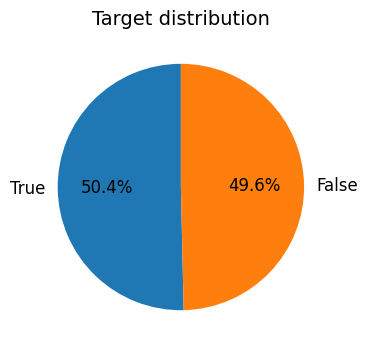

In [10]:
plt.figure(figsize=(4, 4))

train["Transported"].value_counts().plot.pie(
    autopct="%1.1f%%",
    textprops={"fontsize": 12},
    startangle=90
)

plt.title("Target distribution", fontsize=14)
plt.ylabel("")
plt.show()


**Continuous features**

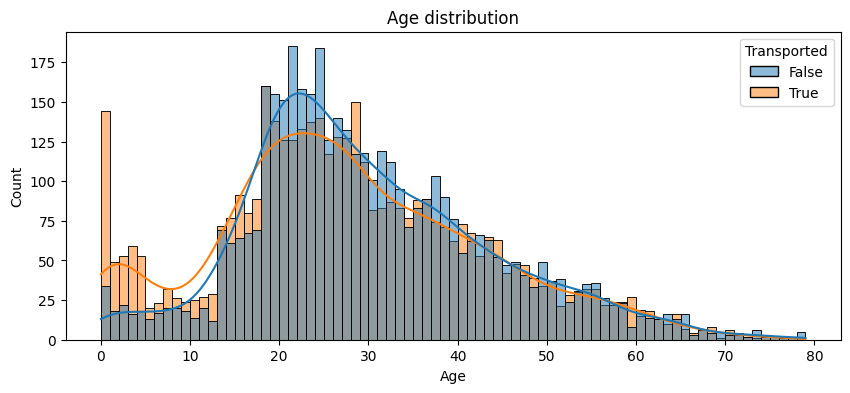

In [11]:
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

* **Основная масса пассажиров** — это молодые люди в возрасте от 18 до 40 лет.
* **Детей до ~13 лет** заметно меньше, но они тоже присутствуют.
* После **40 лет** количество пассажиров постепенно снижается, вплоть 80 лет.
* **Распределение по классам (Transported = True / False)**: дети до 18 имеют большая часть подпадает под `Transported = True`, у взрослых с 18 по 40 лет наблюдается обратная картина, дальше группы в среднем равны.

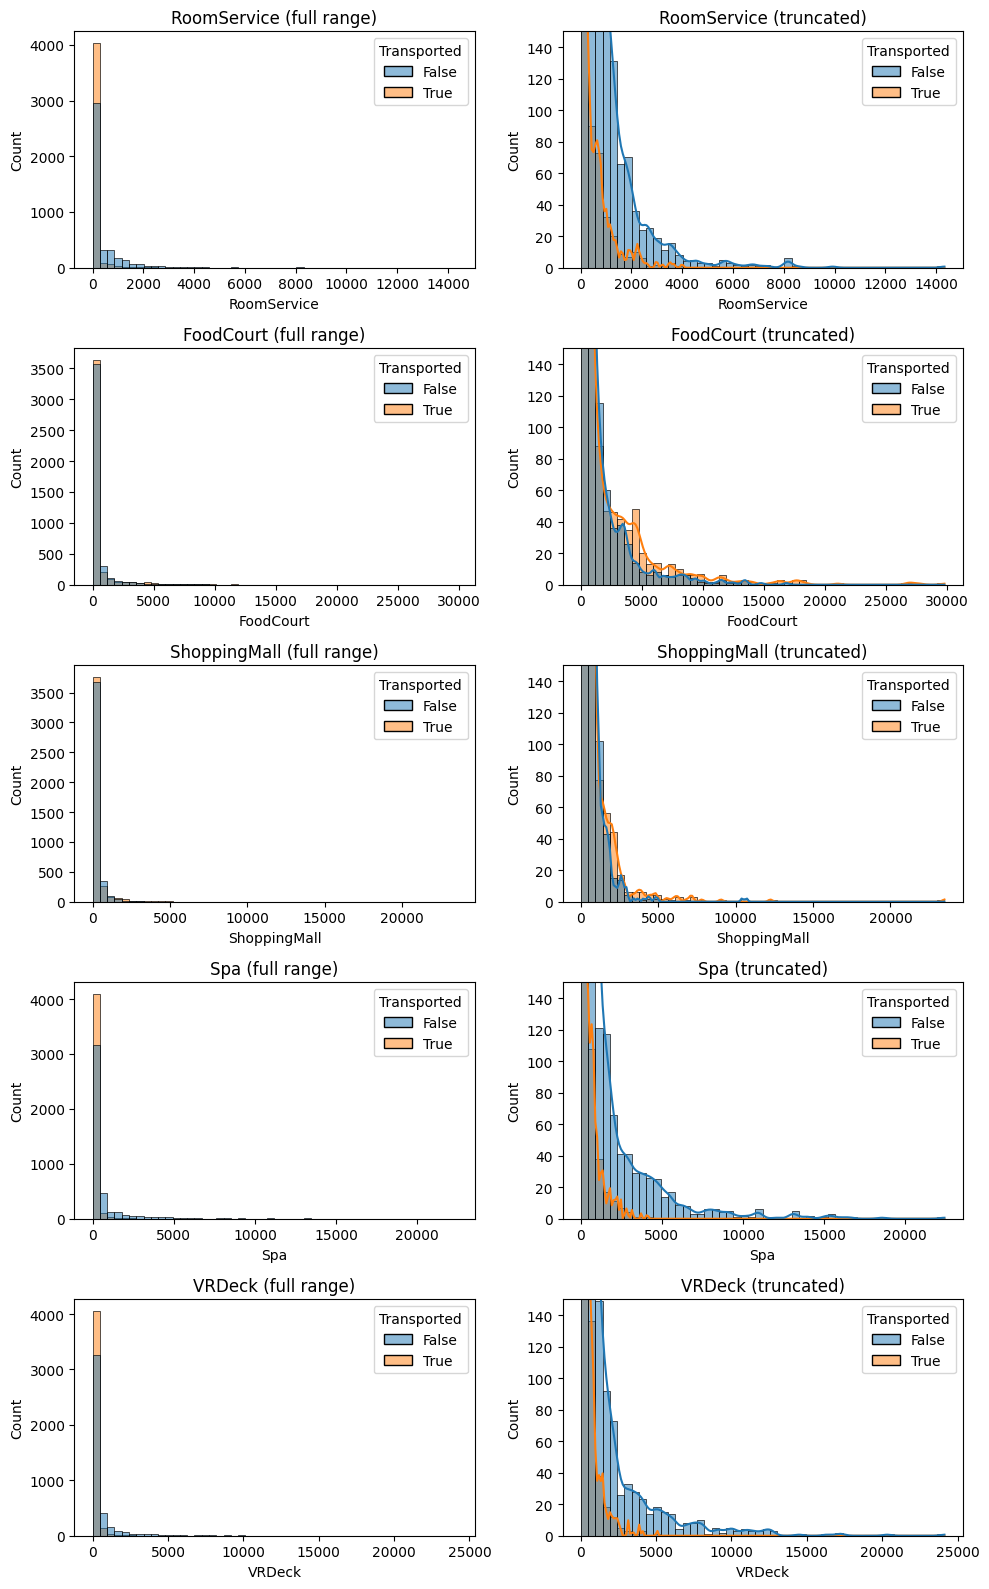

In [12]:
expenditureFeatures = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

fig, axes = plt.subplots(5, 2, figsize=(10, 16))

for rowIndex, featureName in enumerate(expenditureFeatures):
    sns.histplot(
        data=train,
        x=featureName,
        bins=50,
        hue="Transported",
        ax=axes[rowIndex, 0]
    )
    axes[rowIndex, 0].set_title(f"{featureName} (full range)")
    axes[rowIndex, 0].set_ylabel("Count")

    sns.histplot(
        data=train,
        x=featureName,
        bins=50,
        hue="Transported",
        kde=True,
        ax=axes[rowIndex, 1]
    )
    axes[rowIndex, 1].set_ylim([0, 150])
    axes[rowIndex, 1].set_title(f"{featureName} (truncated)")
    axes[rowIndex, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()


* **Большинство людей вообще не тратят деньги** (что видно на левом графике).
* Распределение расходов **убывает экспоненциально** (что видно на правом графике).
* Есть небольшое количество **выбросов**.
* Те, кто были транспортированы, как правило **тратили меньше**.
* У RoomService, Spa и VRDeck **распределения отличаются** от FoodCourt и ShoppingMall — их можно рассматривать как «люксовые» против «базовых» удобств.

**Categorical features**

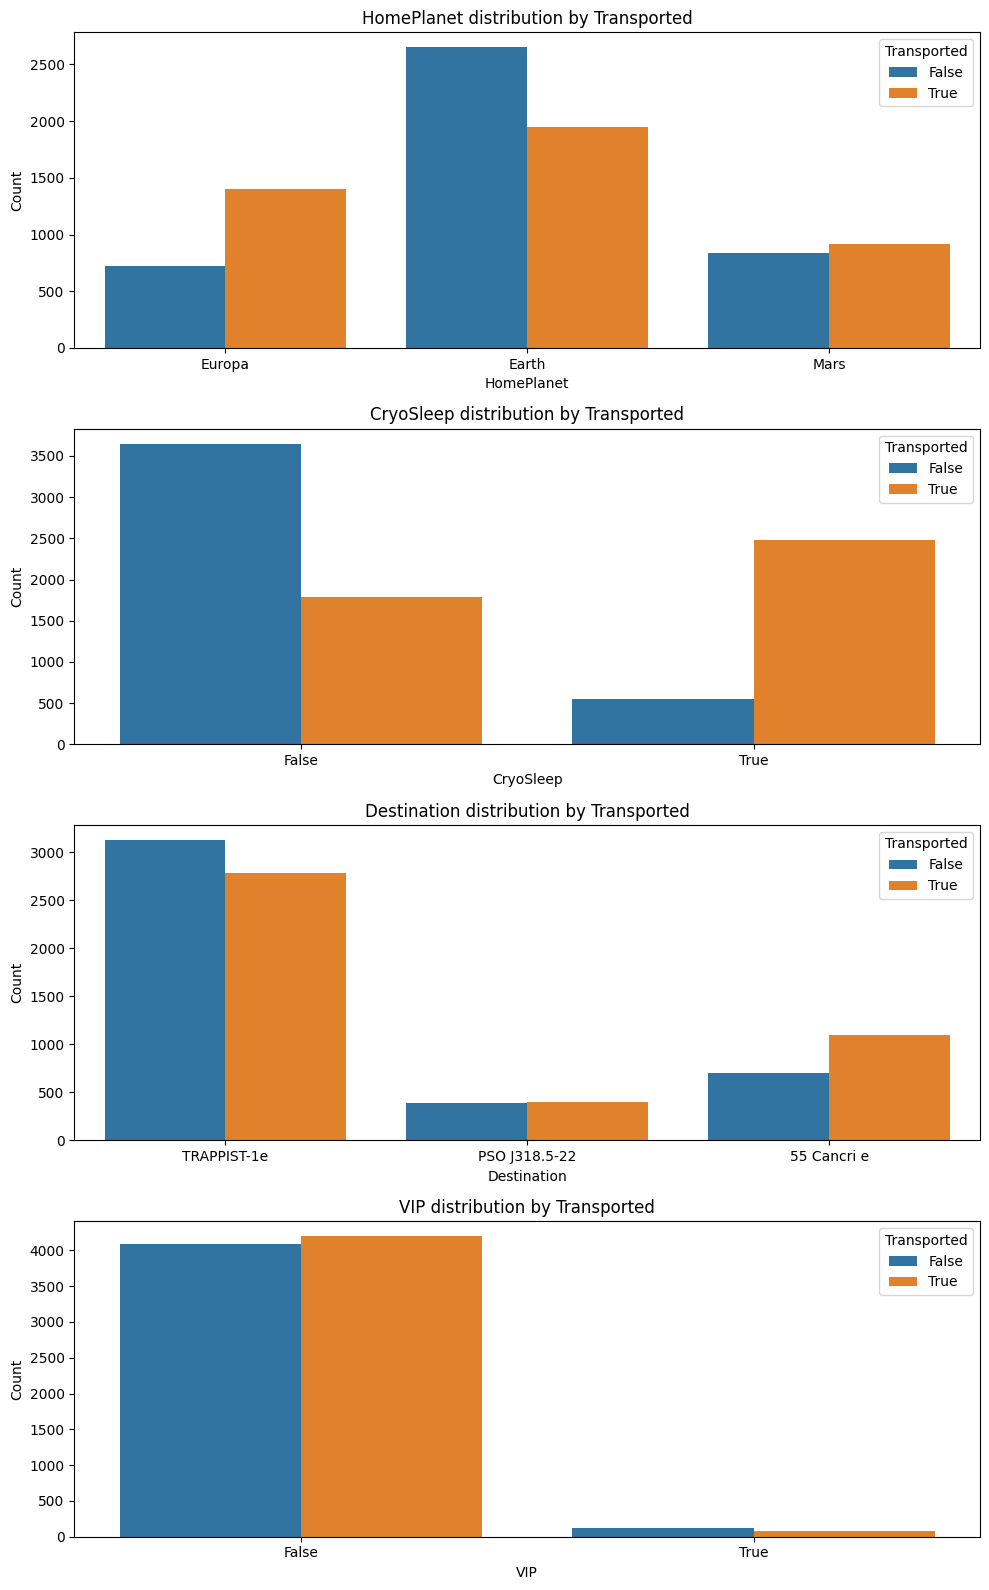

In [13]:
categoricalFeatures = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

fig, axes = plt.subplots(nrows=len(categoricalFeatures), ncols=1, figsize=(10, 16))

for index, featureName in enumerate(categoricalFeatures):
    sns.countplot(
        data=train,
        x=featureName,
        hue="Transported",
        ax=axes[index]
    )
    axes[index].set_title(f"{featureName} distribution by Transported")
    axes[index].set_ylabel("Count")

plt.tight_layout()
plt.show()

* Выживших **становилось все меньше**, если следовать порядку родных планет: Европа -> Марс -> Земля.
* Криосон **значительно влияет** на шанс быть перенесенным.
* С местом прибытия **похожая ситуация, что и родными планетами**, но в меньшей степени, если распологать их в порядке: `55 Cancri e` -> `PSO J318.5-22` -> `TRAPPIST-1e`.
* `VIP` не на что **не влияет**.

In [14]:
qualitativeFeatures=['PassengerId', 'Cabin' ,'Name']

train[qualitativeFeatures].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


# Missing values

In [15]:
isNumericDtype = pd.api.types.is_numeric_dtype

trainCopy = train.reset_index(drop=True).copy()
testCopy = test.reset_index(drop=True).copy()

combined = pd.concat([trainCopy, testCopy], axis=0, sort=False, ignore_index=True)
combined["isTrain"] = combined.index < len(trainCopy)

amenityColumns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
combined.loc[combined["CryoSleep"] == True, amenityColumns] = 0.0
groupMedian = combined.groupby(["VIP", "CryoSleep"])[amenityColumns].transform("median")
combined[amenityColumns] = combined[amenityColumns].fillna(groupMedian)
combined[amenityColumns] = combined[amenityColumns].fillna(combined[amenityColumns].median())

modeByVip = combined.groupby("VIP")["HomePlanet"].agg(
    lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan
)
combined["HomePlanet"] = combined["HomePlanet"].fillna(combined["VIP"].map(modeByVip))
combined.loc[(combined["VIP"] == False) & (combined["HomePlanet"].isna()), "HomePlanet"] = "Earth"
combined.loc[(combined["VIP"] == True)  & (combined["HomePlanet"].isna()), "HomePlanet"]  = "Europa"
combined["HomePlanet"] = combined["HomePlanet"].fillna("Earth")

medianAgeUnder61 = combined.loc[combined["Age"] < 61, "Age"].median()
combined["Age"] = combined["Age"].fillna(medianAgeUnder61)

for columnName in combined.columns:
    if columnName == "Transported":
        continue
    if combined[columnName].isna().sum() == 0:
        continue
    if isNumericDtype(combined[columnName]):
        combined[columnName].fillna(combined[columnName].median(), inplace=True)
    else:
        modeSeries = combined[columnName].mode()
        if not modeSeries.empty:
            combined[columnName].fillna(modeSeries.iloc[0], inplace=True)
        else:
            combined[columnName].fillna("Missing", inplace=True)

print(combined.isnull().sum())

train = combined.loc[combined["isTrain"], combined.columns.difference(["isTrain"])].reset_index(drop=True)
test  = combined.loc[~combined["isTrain"], combined.columns.difference(["isTrain"])].reset_index(drop=True)


PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported     4277
isTrain            0
dtype: int64


# Feature engineering

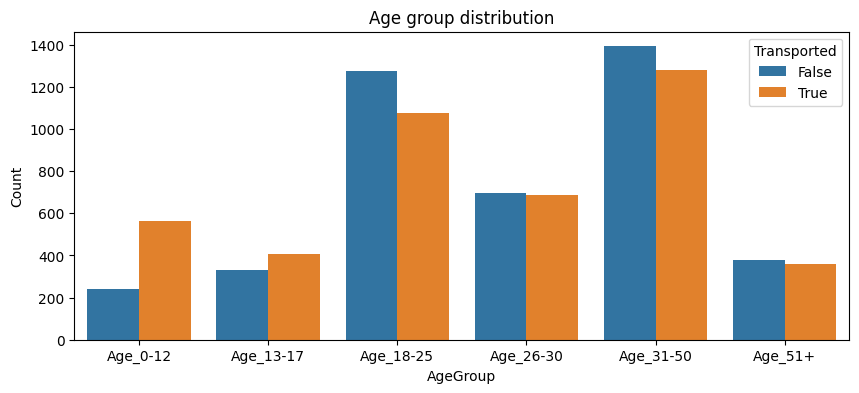

In [16]:
def createAgeGroups(dataFrame):
    bins = [0, 12, 17, 25, 30, 50, float("inf")]
    labels = ["Age_0-12", "Age_13-17", "Age_18-25", "Age_26-30", "Age_31-50", "Age_51+"]
    dataFrame["AgeGroup"] = pd.cut(dataFrame["Age"], bins=bins, labels=labels, include_lowest=True)
    return dataFrame

train = createAgeGroups(train)
test = createAgeGroups(test)

plt.figure(figsize=(10, 4))
sns.countplot(
    data=train,
    x="AgeGroup",
    hue="Transported",
    order=["Age_0-12", "Age_13-17", "Age_18-25", "Age_26-30", "Age_31-50", "Age_51+"]
)
plt.title("Age group distribution")
plt.ylabel("Count")
plt.show()

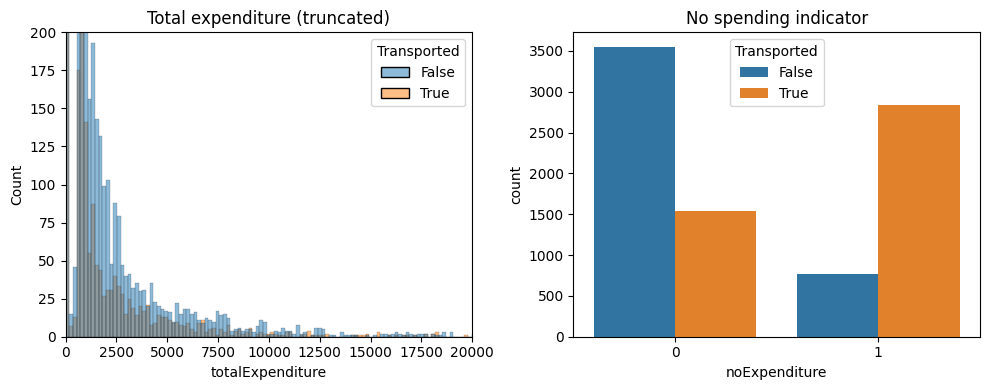

In [17]:
def addExpenditureFeatures(dataFrame, featureList):
    dataFrame["totalExpenditure"] = dataFrame[featureList].sum(axis=1)
    dataFrame["noExpenditure"] = (dataFrame["totalExpenditure"] == 0).astype(int)
    return dataFrame

train = addExpenditureFeatures(train, expenditureFeatures)
test = addExpenditureFeatures(test, expenditureFeatures)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(
    data=train,
    x="totalExpenditure",
    hue="Transported",
    bins=200,
    ax=axes[0]
)
axes[0].set_title("Total expenditure (truncated)")
axes[0].set_ylim([0, 200])
axes[0].set_xlim([0, 20000])

sns.countplot(
    data=train,
    x="noExpenditure",
    hue="Transported",
    ax=axes[1]
)
axes[1].set_title("No spending indicator")

fig.tight_layout()
plt.show()

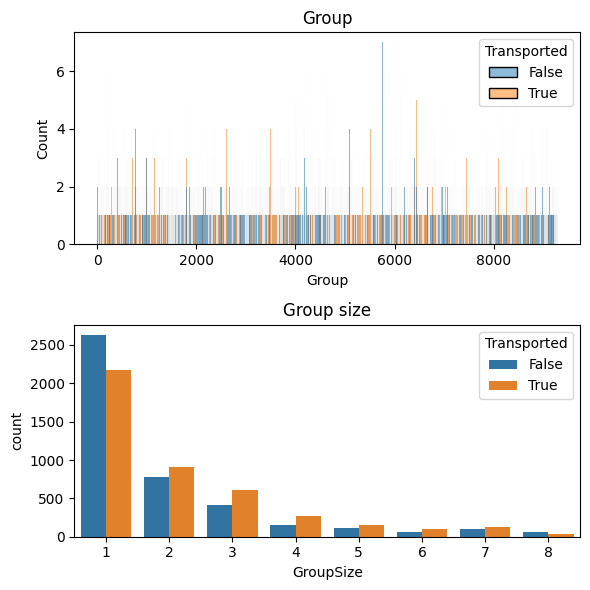

In [18]:
def addGroupFeatures(trainDataFrame, testDataFrame):
    trainDataFrame["Group"] = trainDataFrame["PassengerId"].str.split("_", expand=True)[0].astype(int)
    testDataFrame["Group"] = testDataFrame["PassengerId"].str.split("_", expand=True)[0].astype(int)

    combinedGroups = pd.concat([trainDataFrame["Group"], testDataFrame["Group"]])
    groupSizeMapping = combinedGroups.value_counts().to_dict()

    trainDataFrame["GroupSize"] = trainDataFrame["Group"].map(groupSizeMapping)
    testDataFrame["GroupSize"] = testDataFrame["Group"].map(groupSizeMapping)

    return trainDataFrame, testDataFrame

train, test = addGroupFeatures(train, test)

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

sns.histplot(
    data=train,
    x="Group",
    hue="Transported",
    binwidth=1,
    ax=axes[0]
)
axes[0].set_title("Group")

sns.countplot(
    data=train,
    x="GroupSize",
    hue="Transported",
    ax=axes[1]
)
axes[1].set_title("Group size")

fig.tight_layout()
plt.show()


* Шанс транспортировки при путешествии без группы меньше, чем при размере группы >1.

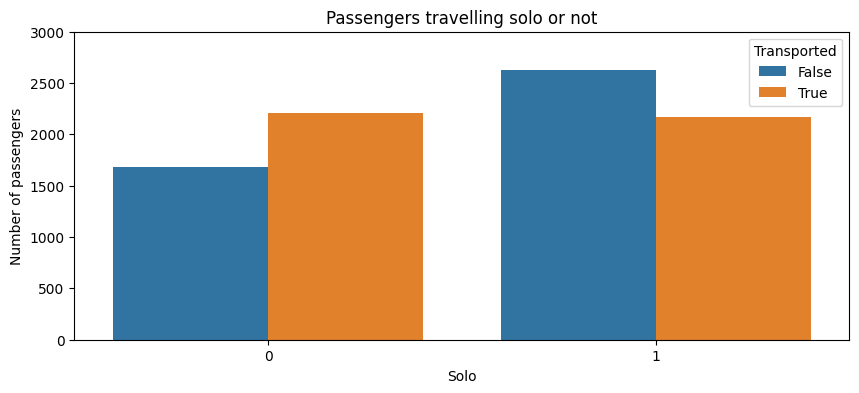

In [19]:
def addSoloFeature(dataFrame):
    dataFrame["Solo"] = (dataFrame["GroupSize"] == 1).astype(int)
    return dataFrame

train = addSoloFeature(train)
test = addSoloFeature(test)

plt.figure(figsize=(10, 4))
sns.countplot(data=train, x="Solo", hue="Transported")
plt.title("Passengers travelling solo or not")
plt.ylim(0, 3000)
plt.xlabel("Solo")
plt.ylabel("Number of passengers")
plt.show()


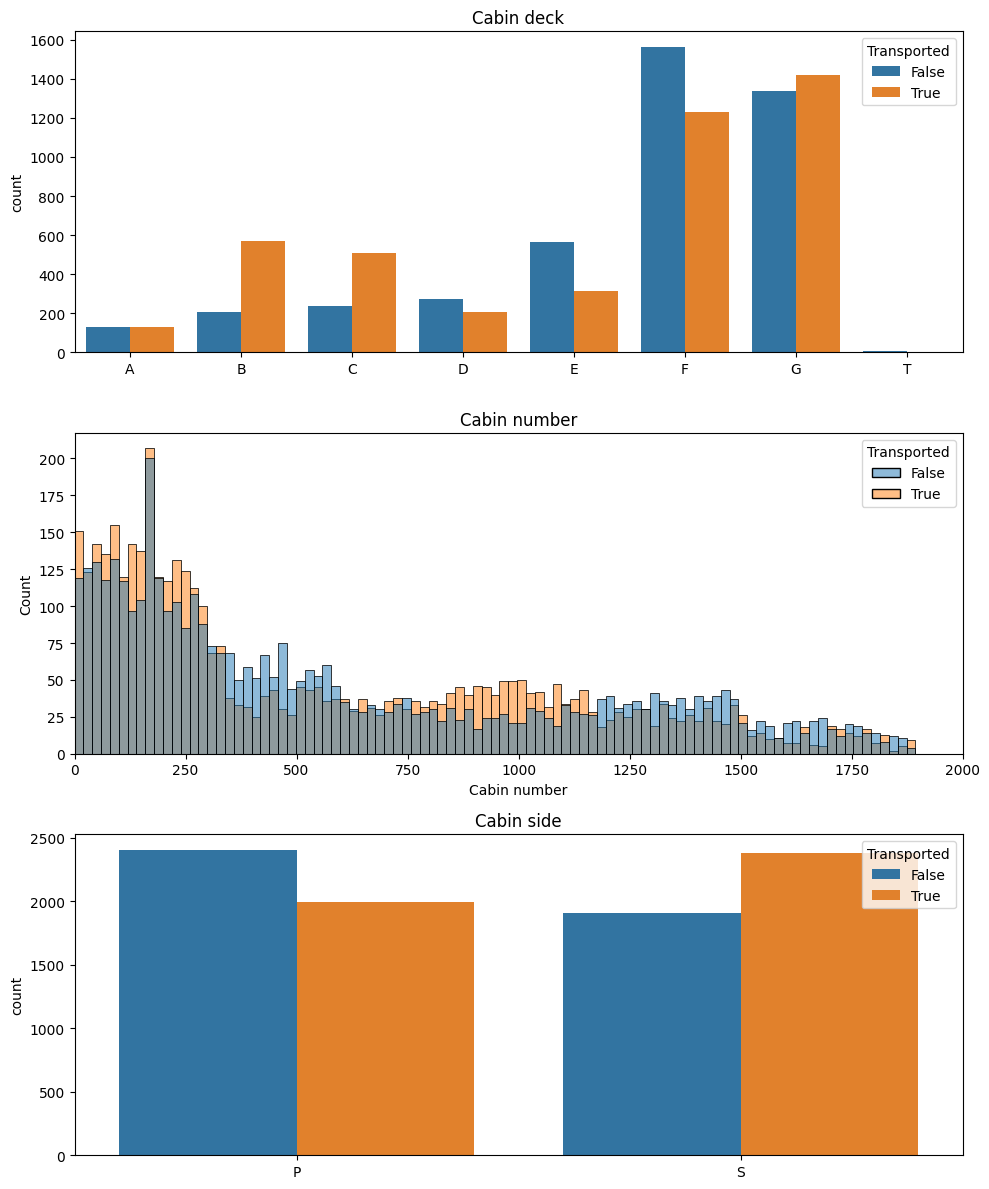

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extractCabinFeatures(dataFrame, cabinColumn="Cabin", dropOriginal=True):
    cabinSplit = dataFrame[cabinColumn].str.split("/", expand=True)

    dataFrame["CabinDeck"] = cabinSplit[0]
    dataFrame["CabinNumber"] = cabinSplit[1].astype(float)
    dataFrame["CabinSide"] = cabinSplit[2]

    if dropOriginal:
        dataFrame = dataFrame.drop(columns=[cabinColumn])

    return dataFrame


def plotCabinFeatures(dataFrame):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    deckOrder = ["A", "B", "C", "D", "E", "F", "G", "T"]
    sns.countplot(data=dataFrame, x="CabinDeck", hue="Transported",
                  order=deckOrder, ax=axes[0])
    axes[0].set_title("Cabin deck")
    axes[0].set_xlabel("")
    axes[0].legend(title="Transported")

    sns.histplot(data=dataFrame, x="CabinNumber", hue="Transported", binwidth=20, ax=axes[1])
    axes[1].set_title("Cabin number")
    axes[1].set_xlim(0, 2000)
    axes[1].set_xlabel("Cabin number")

    sns.countplot(data=dataFrame, x="CabinSide", hue="Transported", ax=axes[2])
    axes[2].set_title("Cabin side")
    axes[2].set_xlabel("")
    axes[2].legend(title="Transported")

    fig.tight_layout()
    plt.show()


train = extractCabinFeatures(train)
test = extractCabinFeatures(test)

plotCabinFeatures(train)

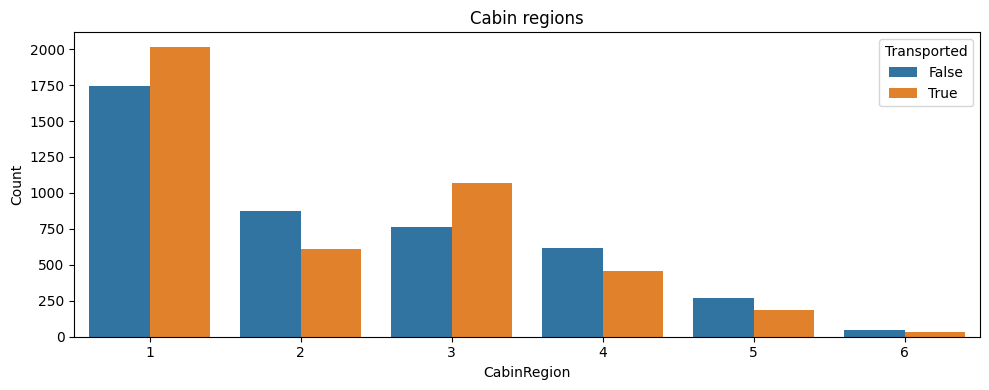

In [21]:
def createCabinRegions(dataFrame, binEdges=None):
    if binEdges is None:
        binEdges = [0, 300, 600, 1150, 1500, 1800, np.inf]

    nRegions = len(binEdges) - 1
    labels = list(range(1, nRegions + 1))

    dataFrame["CabinRegion"] = pd.cut(dataFrame["CabinNumber"],
                              bins=binEdges,
                              labels=labels,
                              include_lowest=True,
                              right=False)

    return dataFrame


binEdges = [0, 300, 600, 1150, 1500, 1800, np.inf]

trainDataFrame = createCabinRegions(train, binEdges=binEdges)
testDataFrame  = createCabinRegions(test,  binEdges=binEdges)

plt.figure(figsize=(10, 4))
sns.countplot(data=trainDataFrame, x="CabinRegion", hue="Transported")
plt.title("Cabin regions")
plt.xlabel("CabinRegion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

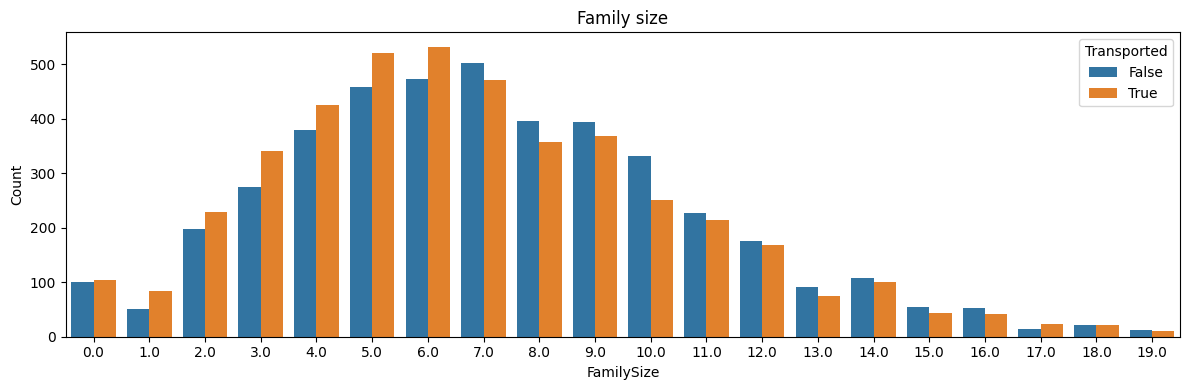

In [23]:
train['Surname'] = train['Name'].str.split().str[-1]
test['Surname']  = test['Name'].str.split().str[-1]

combinedSurnameCounts = pd.concat([train['Surname'], test['Surname']]).value_counts().to_dict()

train['FamilySize'] = train['Surname'].map(combinedSurnameCounts).astype(float)
test['FamilySize']  = test['Surname'].map(combinedSurnameCounts).astype(float)

train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

train.loc[train['FamilySize'] > 100, 'FamilySize'] = 0
test.loc[test['FamilySize']  > 100, 'FamilySize'] = 0

plt.figure(figsize=(12, 4))
sns.countplot(data=train, x='FamilySize', hue='Transported')
plt.title('Family size')
plt.xlabel('FamilySize')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [24]:
test.columns

Index(['Age', 'CryoSleep', 'Destination', 'FoodCourt', 'HomePlanet',
       'PassengerId', 'RoomService', 'ShoppingMall', 'Spa', 'Transported',
       'VIP', 'VRDeck', 'AgeGroup', 'totalExpenditure', 'noExpenditure',
       'Group', 'GroupSize', 'Solo', 'CabinDeck', 'CabinNumber', 'CabinSide',
       'CabinRegion', 'Surname', 'FamilySize'],
      dtype='object')

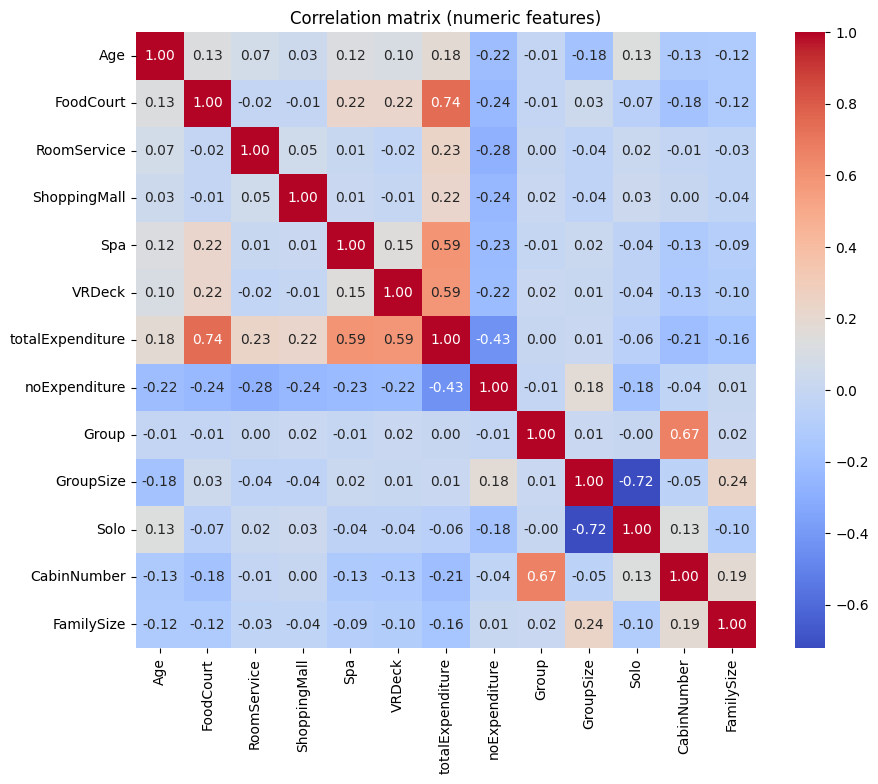

In [25]:
numericColumns = train.select_dtypes(include="number").columns

plt.figure(figsize=(10, 8))
sns.heatmap(train[numericColumns].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix (numeric features)")
plt.show()

In [ ]:
def cramersV(x, y):
    confusionMatrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusionMatrix)[0]
    n = confusionMatrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusionMatrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

categoricalColumns = train.select_dtypes(exclude="number").columns.drop("Transported")

catCorr = pd.DataFrame(index=categoricalColumns, columns=categoricalColumns)
for col1 in categoricalColumns:
    for col2 in categoricalColumns:
        catCorr.loc[col1, col2] = cramersV(train[col1], train[col2])

catCorr = catCorr.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(catCorr, annot=True, fmt=".2f", cmap="viridis")
plt.title("Cramér's V matrix (categorical features)")
plt.show()

# Preprocessing

In [27]:
featureColumns = train.columns.drop(["Transported", "PassengerId", "Age"])

trainX = train[featureColumns].copy()
trainY = train["Transported"].copy()
trainY = trainY.astype(int)

testX = test[featureColumns].copy()

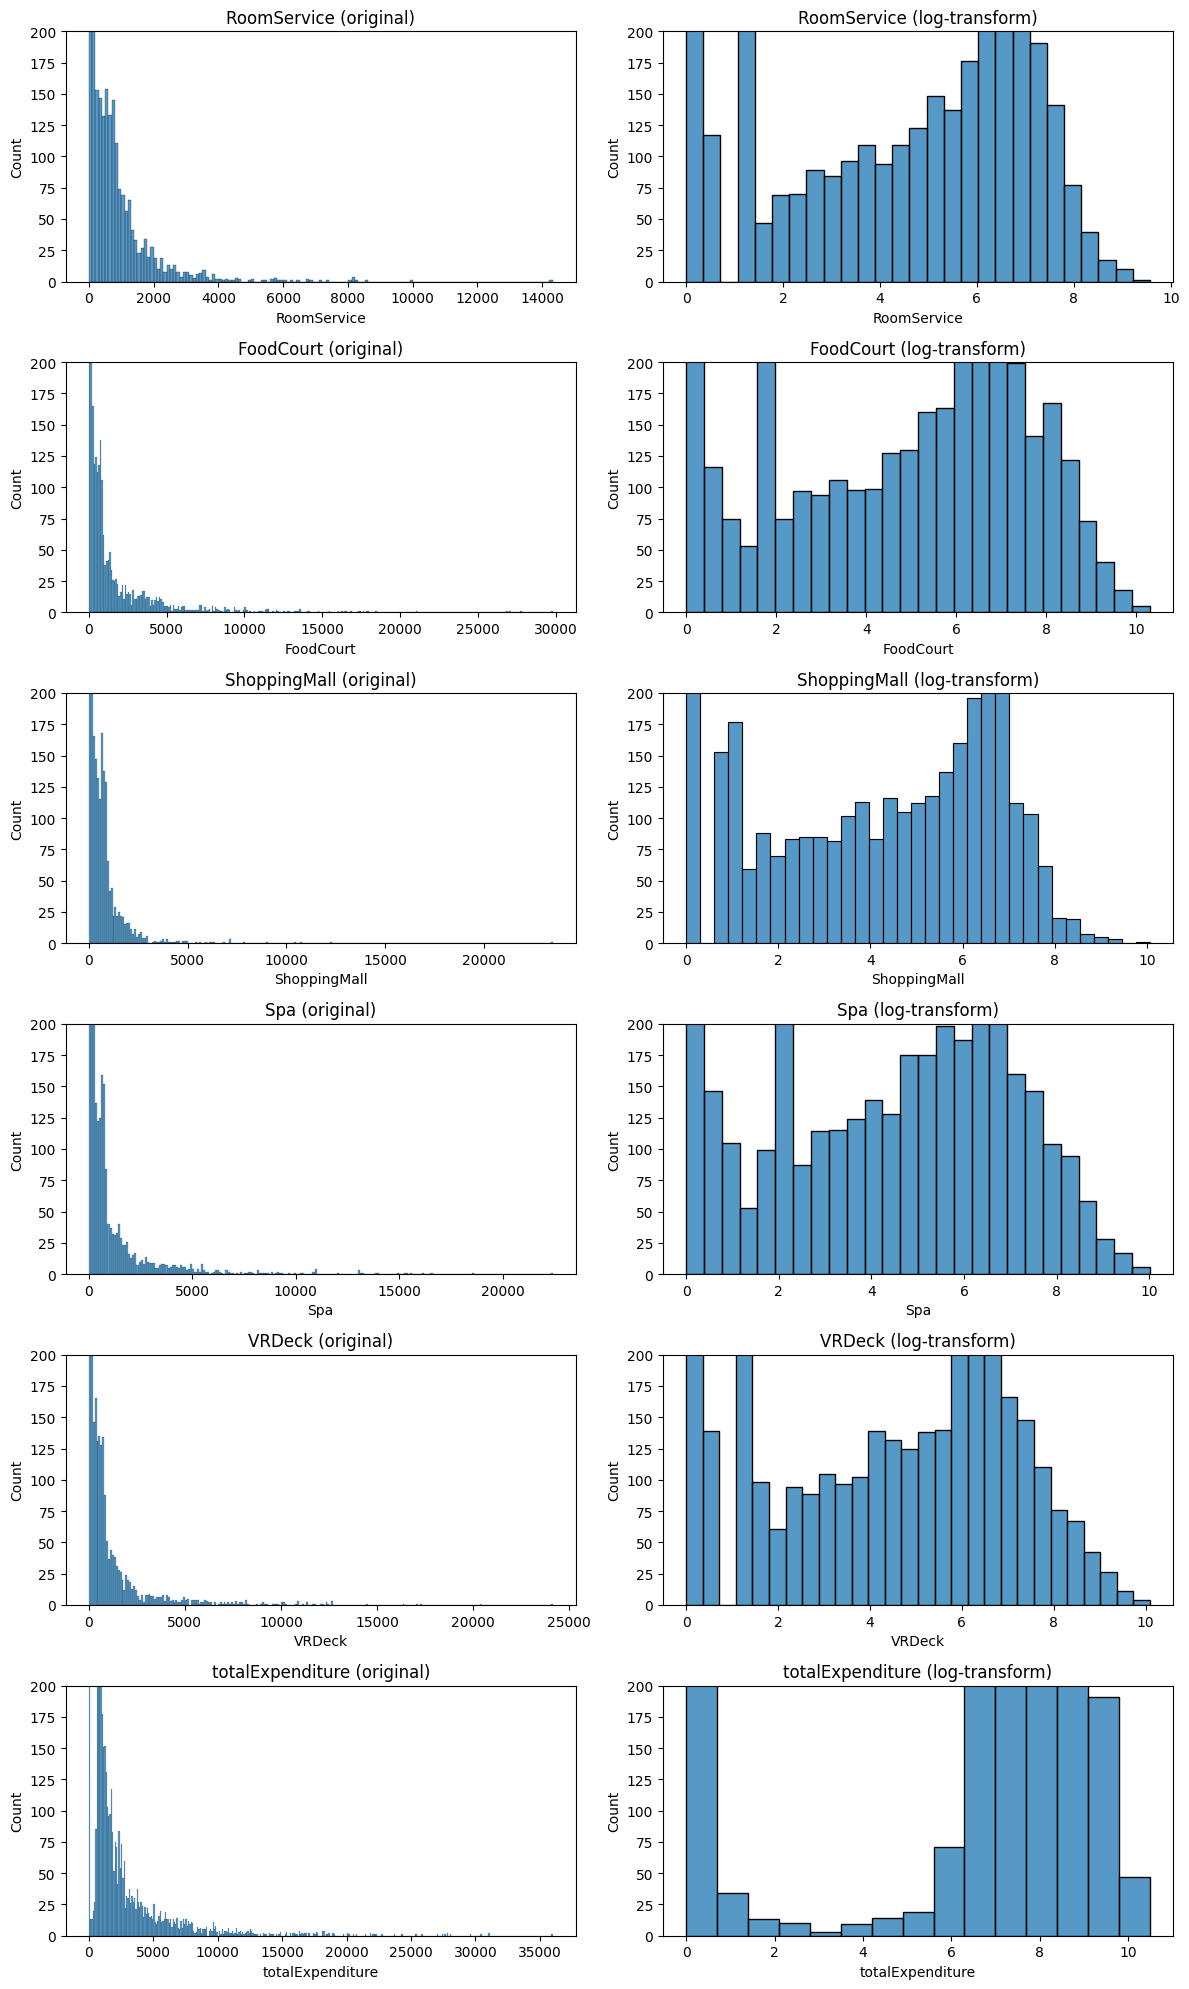

In [28]:
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','totalExpenditure']):
    plt.subplot(6, 2, 2*i + 1)
    sns.histplot(trainX[col], binwidth=100)
    plt.ylim([0, 200])
    plt.title(f'{col} (original)')

    plt.subplot(6, 2, 2*i + 2)
    sns.histplot(np.log1p(trainX[col]))
    plt.ylim([0, 200])
    plt.title(f'{col} (log-transform)')

fig.tight_layout()
plt.show()

for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','totalExpenditure']:
    trainX[col]=np.log1p(trainX[col])
    testX[col]=np.log1p(trainX[col])


In [29]:
numericalCols = trainX.select_dtypes(include=['number']).columns.tolist()
categoricalCols = trainX.select_dtypes(exclude=['number']).columns.tolist()

numericalTransformer = Pipeline(steps=[('scaler', StandardScaler())])
categoricalTransformer = Pipeline(steps=[('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numericalTransformer, numericalCols),
        ('cat', categoricalTransformer, categoricalCols)
    ]
)

trainProcessedX = preprocessor.fit_transform(trainX)
testProcessedX  = preprocessor.transform(testX)

try:
    featureNames = preprocessor.get_feature_names_out(trainX.columns)
except Exception:
    featureNames = [f"f_{i}" for i in range(trainProcessedX.shape[1])]

print("Processed train shape:", trainProcessedX.shape)
print("Processed test shape: ", testProcessedX.shape)
print("Number of feature names:", len(featureNames))

Processed train shape: (8693, 21)
Processed test shape:  (4277, 21)
Number of feature names: 21


In [30]:
xTrain, XVal, yTrain, yVal = train_test_split(trainProcessedX, trainY, test_size=0.2, random_state=42, stratify=trainY)
xTrain
yTrain

3600    1
1262    1
8612    0
5075    1
4758    0
       ..
4087    1
4406    0
7111    1
426     1
7925    1
Name: Transported, Length: 6954, dtype: int32


--- Training LogisticRegression ---
LogisticRegression accuracy: 0.7786

--- Training RandomForest ---
RandomForest accuracy: 0.8005

--- Training CatBoost ---
CatBoost accuracy: 0.7987


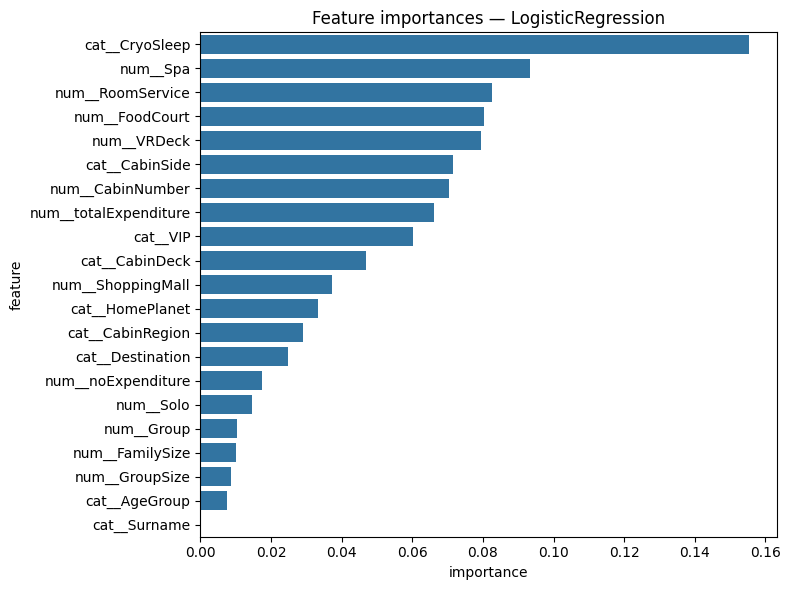

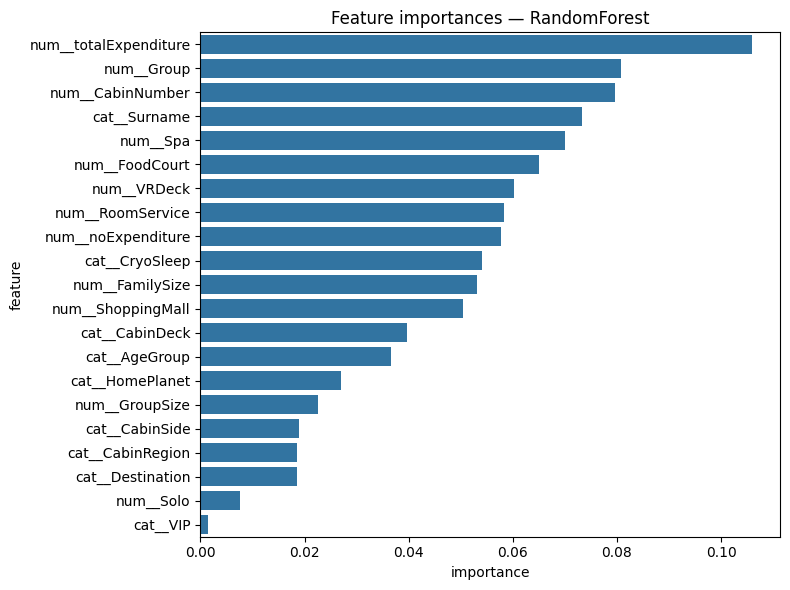

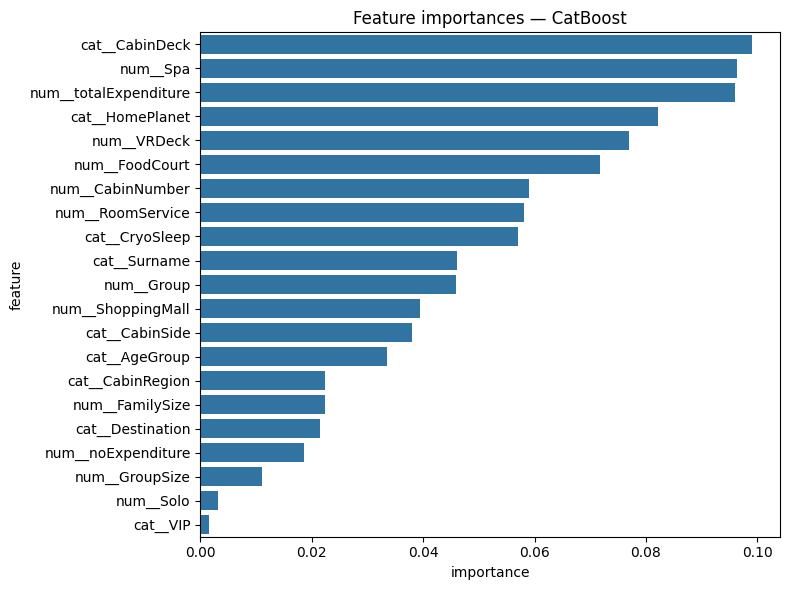

In [31]:
xTrain, XVal, yTrain, yVal = train_test_split(trainProcessedX, trainY, test_size=0.2, random_state=42, stratify=trainY)

modelsDict = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "CatBoost": CatBoostClassifier(iterations=500, verbose=0, random_state=42)
}

trainedModels = {}
for modelName, modelObj in modelsDict.items():
    print(f"\n--- Training {modelName} ---")
    modelObj.fit(xTrain, yTrain)
    yPred = modelObj.predict(XVal)

    acc = accuracy_score(yVal, yPred)
    #reportText = classification_report(yVal, yPred)
    print(f"{modelName} accuracy: {acc:.4f}")
    #print(reportText)
    trainedModels[modelName] = modelObj

def getFeatureImportanceForModel(modelObj, modelName, featureNamesList):
    if modelName == "LogisticRegression":
        coefs = modelObj.coef_
        if coefs.ndim == 2:
            importance = np.mean(np.abs(coefs), axis=0)
        else:
            importance = np.abs(coefs)
        importance = importance.ravel()
    elif hasattr(modelObj, "feature_importances_"):
        importance = modelObj.feature_importances_
    elif modelName == "CatBoost":
        try:
            importance = np.array(modelObj.get_feature_importance(prettified=False))
        except Exception:
            importance = np.zeros(len(featureNamesList))
    else:
        importance = np.zeros(len(featureNamesList))

    importance = np.array(importance, dtype=float)
    if importance.sum() != 0:
        importance = importance / importance.sum()
    return pd.DataFrame({"feature": featureNamesList, "importance": importance})


importanceDfs = {}
for modelName, modelObj in trainedModels.items():
    importanceDfs[modelName] = getFeatureImportanceForModel(modelObj, modelName, featureNames)

for modelName, dfImportance in importanceDfs.items():
    dfTop = dfImportance.sort_values("importance", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(data=dfTop, x="importance", y="feature")
    plt.title(f"Feature importances — {modelName}")
    plt.tight_layout()
    plt.show()

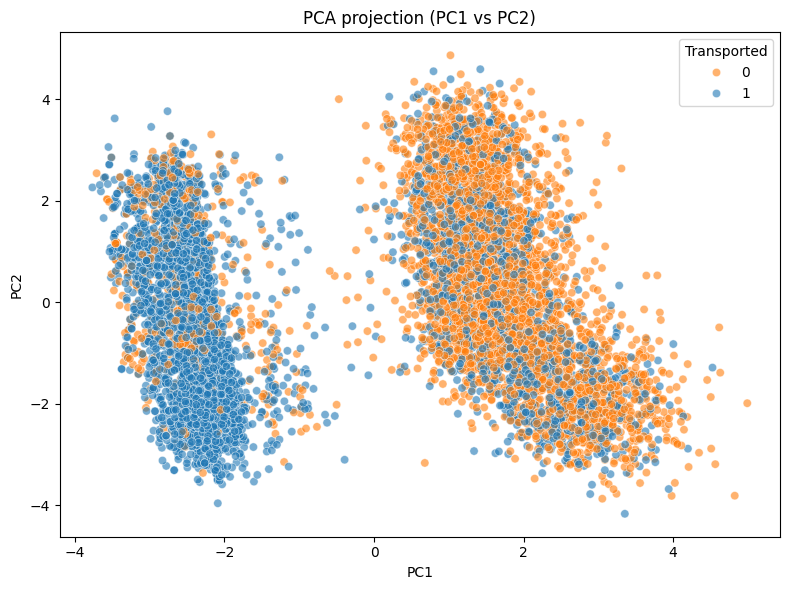

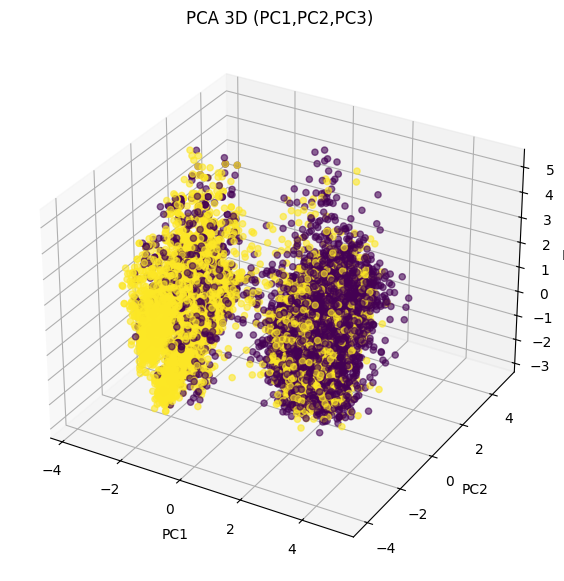

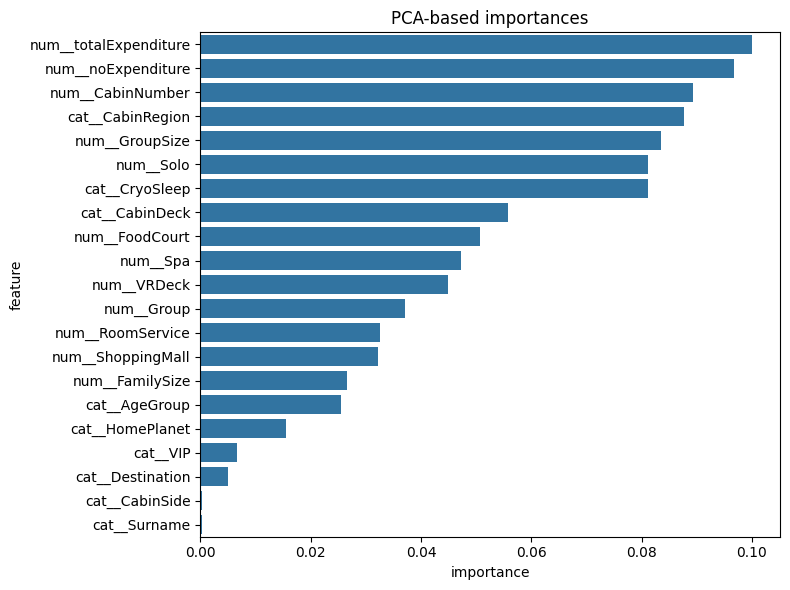

In [32]:
scalerForPca = StandardScaler()
trainForPca = scalerForPca.fit_transform(trainProcessedX)

pca = PCA(n_components=3, random_state=42)
pcaComponents = pca.fit_transform(trainForPca)

plt.figure(figsize=(8,6))
palette = {True: "C0", False: "C1"}
sns.scatterplot(x=pcaComponents[:,0], y=pcaComponents[:,1], hue=trainY, palette=palette, alpha=0.6)
plt.title("PCA projection (PC1 vs PC2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="Transported")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcaComponents[:,0], pcaComponents[:,1], pcaComponents[:,2], c=trainY, alpha=0.6)
ax.set_title("PCA 3D (PC1,PC2,PC3)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
plt.show()

loadings = pca.components_
explained = pca.explained_variance_ratio_
pcaImportancesSquared = np.sum((loadings**2).T * explained.reshape(1, -1), axis=1)
if pcaImportancesSquared.sum() != 0:
    pcaImportancesSquared = pcaImportancesSquared / pcaImportancesSquared.sum()

dfPcaImportanceSquared = pd.DataFrame({"feature": featureNames, "importance": pcaImportancesSquared})
dfPcaTopSquared = dfPcaImportanceSquared.sort_values("importance", ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(data=dfPcaTopSquared, x="importance", y="feature")
plt.title("PCA-based importances")
plt.tight_layout()
plt.show()

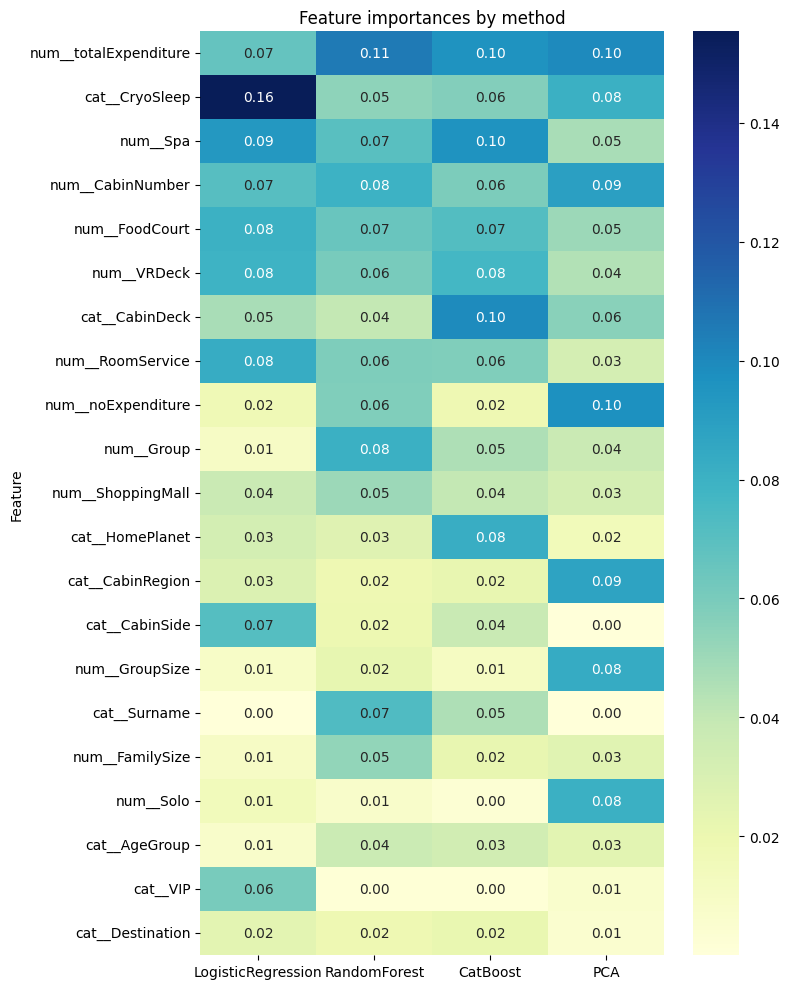

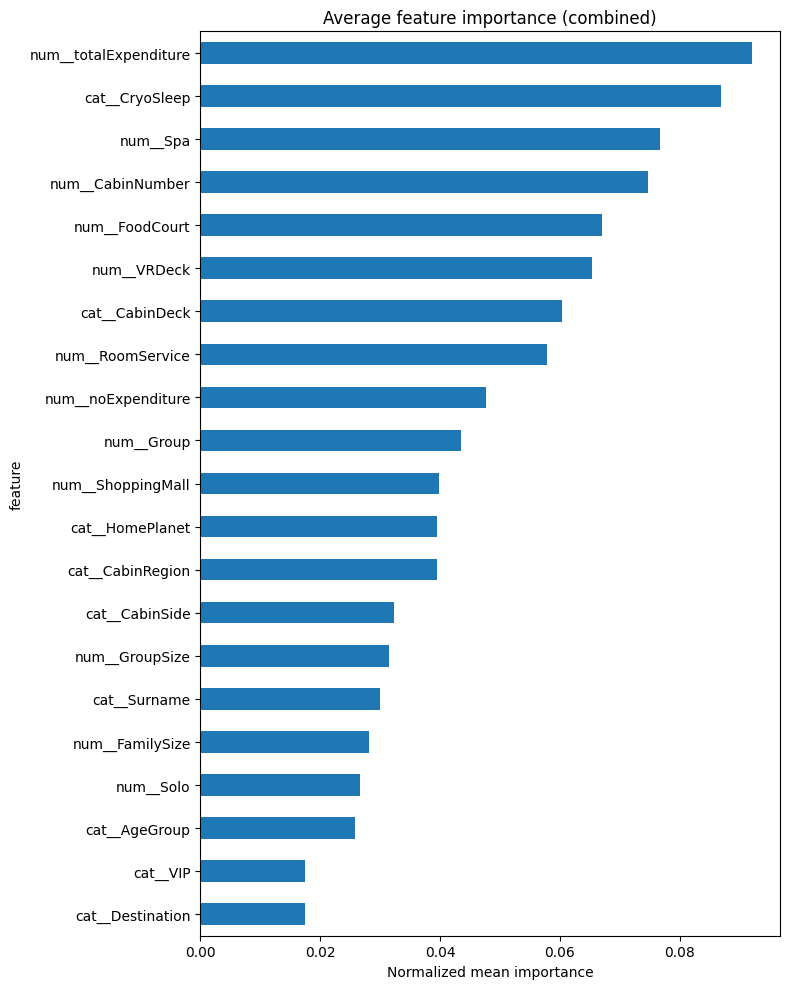

In [33]:
allImportanceDfList = []
for modelName, dfImp in importanceDfs.items():
    tmp = dfImp.copy().set_index("feature")
    tmp.columns = [modelName]
    allImportanceDfList.append(tmp)

tmpPca = dfPcaImportanceSquared.set_index("feature")
tmpPca.columns = ["PCA"]
allImportanceDfList.append(tmpPca)

dfAllImportances = pd.concat(allImportanceDfList, axis=1).fillna(0)

dfAllImportances = dfAllImportances.div(dfAllImportances.sum(axis=0) + 1e-12, axis=1)

dfAllImportances['meanImportance'] = dfAllImportances.mean(axis=1)
dfAllImportances.sort_values('meanImportance', ascending=False, inplace=True)

plt.figure(figsize=(8, 10))
sns.heatmap(dfAllImportances.drop(columns=['meanImportance']), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Feature importances by method")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,10))
dfAllImportances['meanImportance'].plot.barh()
plt.gca().invert_yaxis()
plt.title("Average feature importance (combined)")
plt.xlabel("Normalized mean importance")
plt.tight_layout()
plt.show()

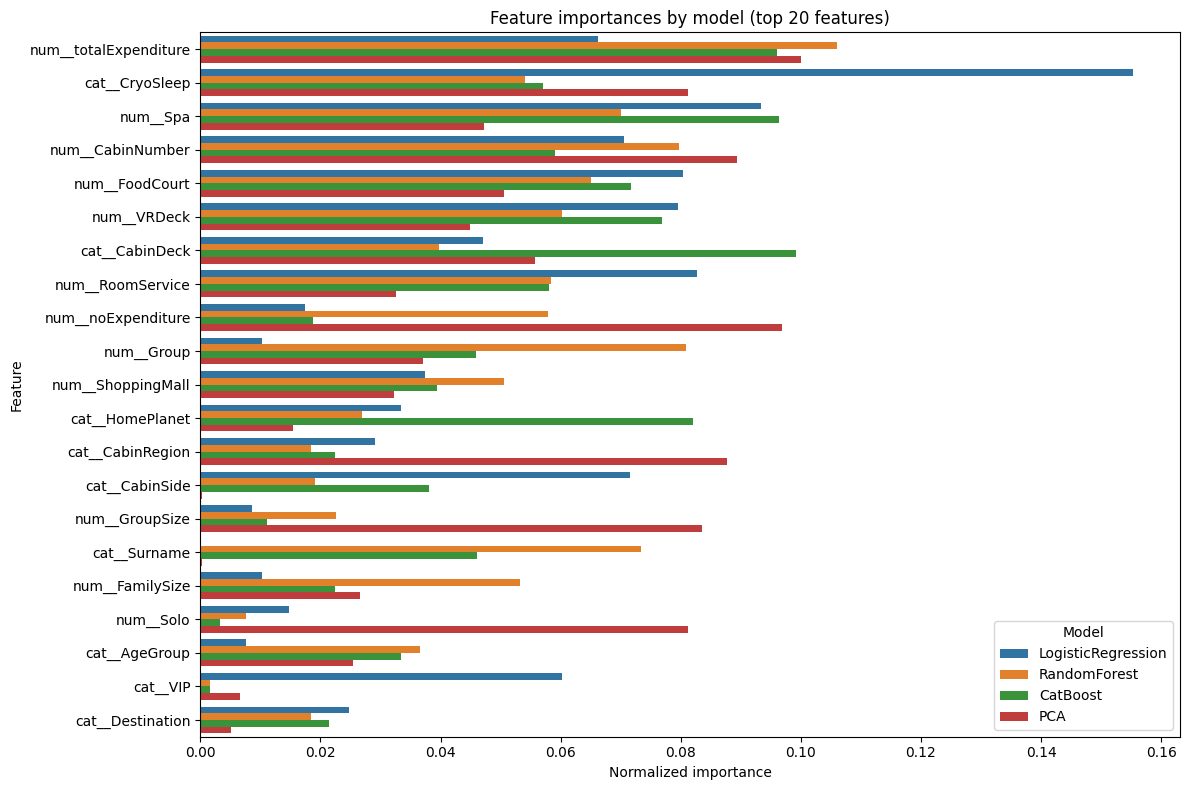

In [178]:
methods = ["LogisticRegression", "RandomForest", "CatBoost", "PCA"]
dfPlot = dfAllImportances[methods].copy()

dfPlot = dfPlot.loc[dfAllImportances['meanImportance'].sort_values(ascending=False).index]
dfPlotReset = dfPlot.reset_index().melt(id_vars="feature", var_name="model", value_name="importance")

plt.figure(figsize=(12, 8))
sns.barplot(data=dfPlotReset, x="importance", y="feature", hue="model")
plt.title("Feature importances by model (top 20 features)")
plt.xlabel("Normalized importance")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.tight_layout()
plt.show()
